## Carga de datos

In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

idpi = 1/plt.rcParams['figure.dpi']

In [2]:
UNINTRESTING_OMEGAS = (0.1, 0.2, 0.3, 0.4, 0.6, 0.65, 0.8, 0.9)
INTRESTING_OMEGAS = (0.5, 0.55)


## CARGA DE DATOS PARA MEDIR DIFERENCIAS ENRTRE CRITERIOS
exports_diff_dfs = []
exports_global_dfs = []
exports_local_dfs = []
for omega in list(UNINTRESTING_OMEGAS) + list(INTRESTING_OMEGAS):
    exports_global_df = pd.read_csv(f"experimentacion/metrics-original-data-true-{omega}/exports.csv")
    exports_global_df["omega"] = omega
    exports_global_df.set_index(["country", "generation"], inplace=True)
    exports_global_dfs.append(exports_global_df)

    exports_local_df = pd.read_csv(f"experimentacion/metrics-original-data-false-{omega}/exports.csv")
    exports_local_df["omega"] = omega
    exports_local_df.set_index(["country", "generation"], inplace=True)
    exports_local_dfs.append(exports_local_df)

    exports_diff_df = exports_global_df - exports_local_df
    exports_diff_df["omega"] = omega

    exports_diff_dfs.append(exports_diff_df)

exports_diff_df = pd.concat(exports_diff_dfs)
exports_diff_df.reset_index(inplace=True)

exports_global_df = pd.concat(exports_global_dfs)
exports_global_df.reset_index(inplace=True)

exports_local_df = pd.concat(exports_local_dfs)
exports_local_df.reset_index(inplace=True)

exports_diff_df

,country,generation,count_exports,omega
0,Afghanistan,0,0,0.10
1,Afr.Other NS,0,0,0.10
2,Africa N.NES,0,0,0.10
3,Albania,0,0,0.10
4,Algeria,0,0,0.10
...,...,...,...,...
39895,Viet Nam,20,54,0.55
39896,Yemen,20,326,0.55
39897,Yugoslavia,20,70,0.55
39898,Zambia,20,109,0.55


In [3]:
exports_global_df_copy = exports_global_df.copy()
exports_global_df_copy["dynamic"] = True
exports_local_df_copy = exports_local_df.copy()
exports_local_df_copy["dynamic"] = False
exports_df = pd.concat([exports_local_df_copy, exports_global_df_copy])
exports_df

,country,generation,count_exports,omega,dynamic
0,Afghanistan,0,41,0.10,False
1,Afr.Other NS,0,9,0.10,False
2,Africa N.NES,0,0,0.10,False
3,Albania,0,90,0.10,False
4,Algeria,0,21,0.10,False
...,...,...,...,...,...
39895,Viet Nam,20,405,0.55,True
39896,Yemen,20,348,0.55,True
39897,Yugoslavia,20,396,0.55,True
39898,Zambia,20,358,0.55,True


In [4]:
original_data = pkl.load(open("data/original_data.pkl", "rb"))
len(original_data["products"]), len(original_data["countries"])

(775, 190)

In [5]:
print(original_data["countries"])

['Afghanistan', 'Afr.Other NS', 'Africa N.NES', 'Albania', 'Algeria', 'Angola', 'Areas NES', 'Argentina', 'Armenia', 'Asia NES', 'Asia West NS', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium-Lux', 'Belize', 'Benin', 'Bermuda', 'Bolivia', 'Bosnia Herzg', 'Br.Antr.Terr', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'CACM NES', 'Cambodia', 'Cameroon', 'Canada', 'Cent.Afr.Rep', 'Chad', 'Chile', 'China', 'China FTZ', 'China HK SAR', 'China MC SAR', 'Colombia', 'Congo', 'Costa Rica', 'Cote Divoire', 'Croatia', 'Cuba', 'Cyprus', 'Czech Rep', 'Dem.Rp.Congo', 'Denmark', 'Djibouti', 'Dominican Rp', 'EEC NES', 'Ecuador', 'Egypt', 'El Salvador', 'Eq.Guinea', 'Estonia', 'Ethiopia', 'Eur.Other NE', 'Falkland Is', 'Fiji', 'Finland', 'Fr Ind O', 'Fr.Guiana', 'France,Monac', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Guadeloupe', 'Guatemala', 'Guinea', 'GuineaBissau', 'Guyana', 'Haiti', 'Honduras

## Gráficos PS fijo

In [6]:
#paises = set(["Argentina", "Brazil", "Korea Rep.", "Germany"])
paises = set(["Argentina", "Germany"])

# Criterio local
df = exports_df[
    exports_df.country.isin(paises) &
    exports_df.omega.isin([0.4,0.5,0.55,0.6,0.65]) &
    (exports_df.generation <= 10)
].copy()
df["dynamic"] = df.dynamic.apply(lambda is_dynamic: "DPS" if is_dynamic else "SPS")
df = df.sort_values("dynamic")
df

,country,generation,count_exports,omega,dynamic
37880,Germany,10,485,0.55,DPS
16600,Germany,3,427,0.60,DPS
16727,Argentina,4,291,0.60,DPS
16790,Germany,4,437,0.60,DPS
16917,Argentina,5,291,0.60,DPS
...,...,...,...,...,...
32940,Germany,5,504,0.50,SPS
33067,Argentina,6,500,0.50,SPS
33130,Germany,6,504,0.50,SPS
32117,Argentina,1,271,0.50,SPS


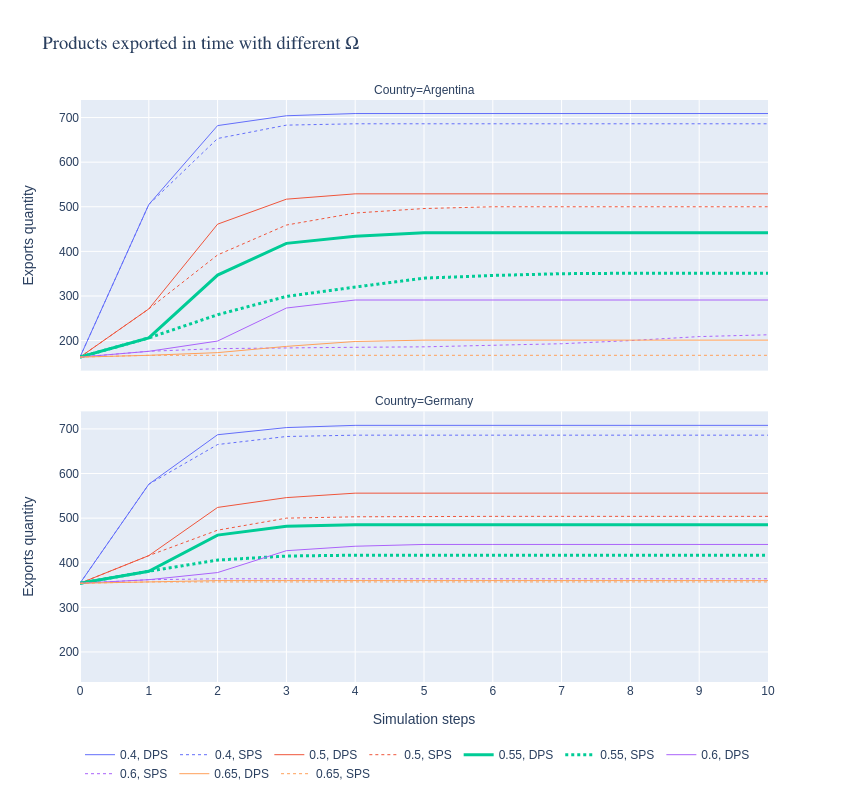

In [37]:
fig = px.line(df.sort_values(["country", "generation", "omega"]),
            x="generation",
            y="count_exports",
            color="omega",
            facet_col="country",
            facet_col_wrap=1,
            height=800,
            width=400,
            line_dash="dynamic",
            title= r"$\text{Products exported in time with different }\Omega$",
            #            title="Cantidad de exportaciones en función de la generación por país y omega para variante local",
            labels={
                "count_exports": "Exports quantity",
                "generation": "Simulation steps",
                "country": "Country"
            })
#fig.for_each_annotation(lambda a: a.update(text=a.text.replace("=", " = ")))
#fig.add_vline(x=10, annotation_text="Fin sugerido de la simulación", annotation_position="bottom right")
#fig.add_hline(y=len(original_data["products"]), annotation_text="Products quantity", opacity=.25)

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    ),
    xaxis2 = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    ),
    legend_title=""
)

def transform_trace(trace):
    if not trace.legendgroup.startswith("0.55"):
        trace.line.width = 1 # Por default es 2
    else:
        trace.line.width = 3 # Por default es 2

fig.for_each_trace(transform_trace)

fig.update_layout(dict(
    legend=dict(orientation="h")
))

fig.show()

In [41]:
from metrics.product_space_graph import ProductSpaceGraph
graph_local = ProductSpaceGraph("experimentacion/original-data-local-0.55/exports_history.pkl")

In [74]:
arg_t4=graph_local.exports_by_country.loc["Argentina"].exports[4].sum()
arg_t0=graph_local.exports_by_country.loc["Argentina"].exports[0].sum()
ger_t4=graph_local.exports_by_country.loc["Germany"].exports[4].sum()
ger_t0=graph_local.exports_by_country.loc["Germany"].exports[0].sum()

(f"Argentina SPS: {round((arg_t4-arg_t0)/arg_t0*100, 1)}%",
 f"Germany SPS: {round((ger_t4-ger_t0)/ger_t0*100,1)}%")

('Argentina SPS: 96.3%', 'Germany SPS: 17.8%')

In [72]:
ger_t4-ger_t0, ger_t0

(63, 354)

In [73]:
arg_t4-arg_t0,arg_t0

(157, 163)

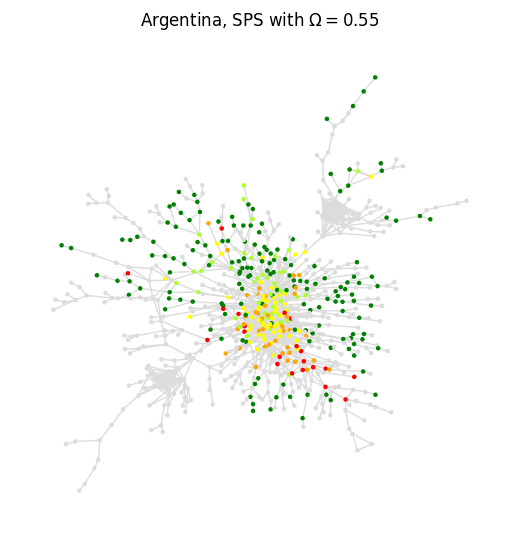

In [9]:
graph_local.plot("Argentina", title="Argentina, SPS with $\Omega = 0.55$", legend_title="Simulation steps",
                 figsize=(500*idpi,500*idpi), node_size=5)

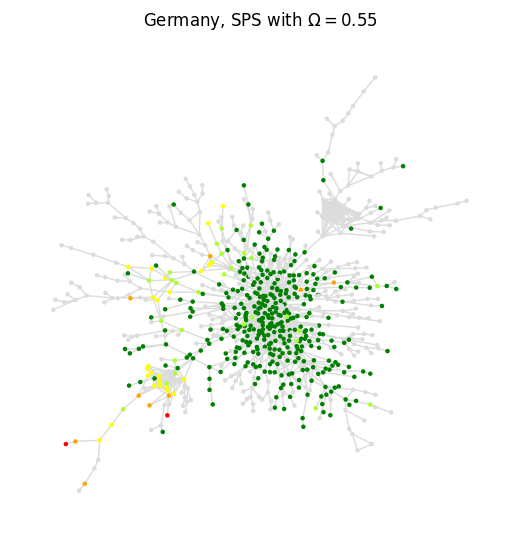

In [10]:
graph_local.plot("Germany", title="Germany, SPS with $\Omega = 0.55$", legend_title="Simulation steps",
                 figsize=(500*idpi,500*idpi), node_size=5)

In [11]:
from metrics.product_space_graph import ProductSpaceGraph
graph_global = ProductSpaceGraph("experimentacion/original-data-global-0.55/exports_history.pkl")
(graph_local.product_discovery("Argentina") == 6.0).sum()

0

In [53]:
arg_t5=graph_global.exports_by_country.loc["Argentina"].exports[5].sum()
arg_t0=graph_global.exports_by_country.loc["Argentina"].exports[0].sum()
ger_t5=graph_global.exports_by_country.loc["Germany"].exports[5].sum()
ger_t0=graph_global.exports_by_country.loc["Germany"].exports[0].sum()

(f"Argentina DPS: {round((arg_t5-arg_t0)/arg_t0*100, 1)}%",
 f"Germany DPS: {round((ger_t5-ger_t0)/ger_t0*100,1)}%")

('Argentina DPS: 171.2%', 'Germany DPS: 37.0%')

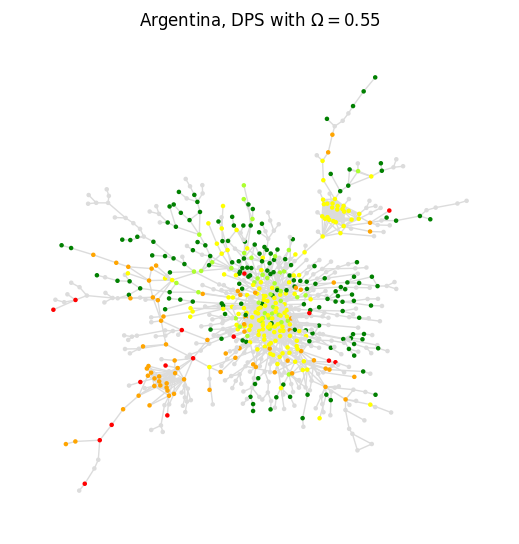

In [12]:
graph_global.plot("Argentina", title="Argentina, DPS with $\Omega = 0.55$",
                 figsize=(500*idpi,500*idpi), node_size=5)

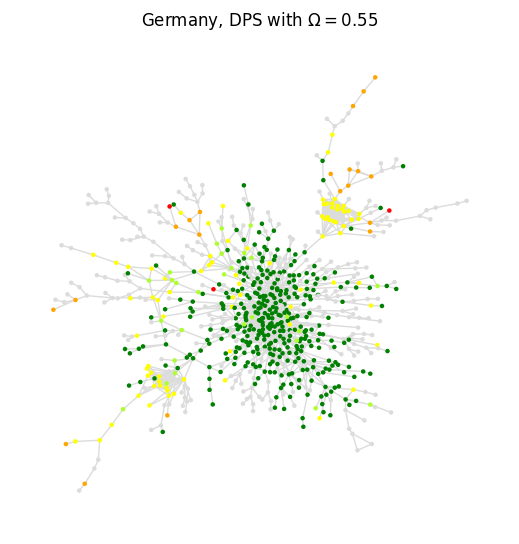

In [13]:
graph_global.plot("Germany", title="Germany, DPS with $\Omega = 0.55$",
                 figsize=(500*idpi,500*idpi), node_size=5)

## Gráficos PS fijo vs dinámico

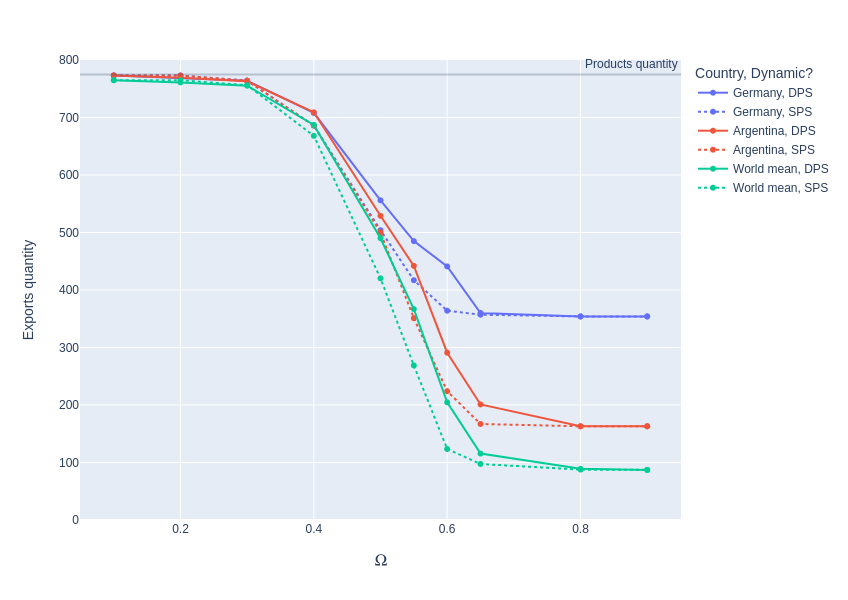

In [14]:
df_ = (exports_df
 .set_index(["generation", "country", "omega"])
 .loc[max(exports_diff_df.generation)]
 .reset_index()
 .sort_values("omega")
)

mean_df = df_.groupby(["omega","dynamic"]).mean().reset_index()
mean_df["country"] = "World mean"
df_ = pd.concat([df_, mean_df])
df_ = df_[df_.country.isin(["Argentina", "World mean", "Germany"])]
df_["dynamic"] = df_.dynamic.apply(lambda is_dynamic: "DPS" if is_dynamic else "SPS")
fig = px.line(
    df_,
    x="omega",
    y="count_exports",
    color="country",
    line_dash="dynamic",
    markers=True,
    height=600,
    range_y=[0,800],
#    title="Exportaciones por país y variante de simulación",
    labels={
        "count_exports": "Exports quantity",
        "country": "Country",
        "omega": "$\Omega$",
        "dynamic": "Dynamic?"
    },
)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("=", " = ")))
fig.add_hline(y=len(original_data["products"]), annotation_text="Products quantity", opacity=.25)
fig.show()

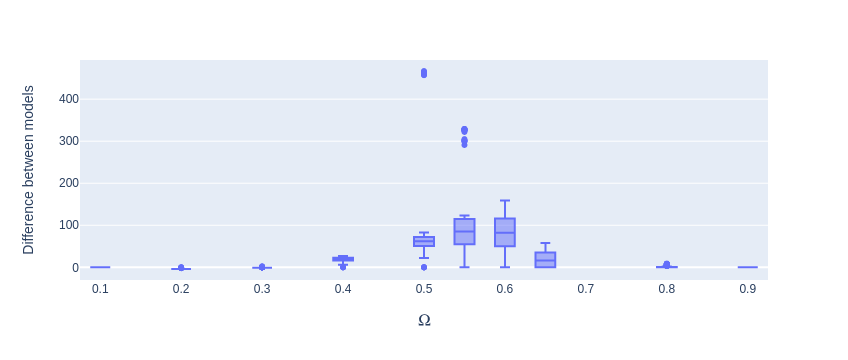

In [15]:
max_diff_df = (
    exports_diff_df
    .set_index(["generation", "country", "omega"])
    .loc[max(exports_diff_df.generation)]
    .max(axis=1)
)
max_diff_df.rename("difference", inplace=True)
fig = px.box(
    max_diff_df.reset_index(),
    x="omega",
    y="difference",
#    title=f"Distribucion de la ventaja de la variante global respecto a la variante local<br>según omega para todos los países (ultima generacion)",
    labels={
        "difference": "Difference between models",
        "omega": "$\Omega$"})
fig.show()

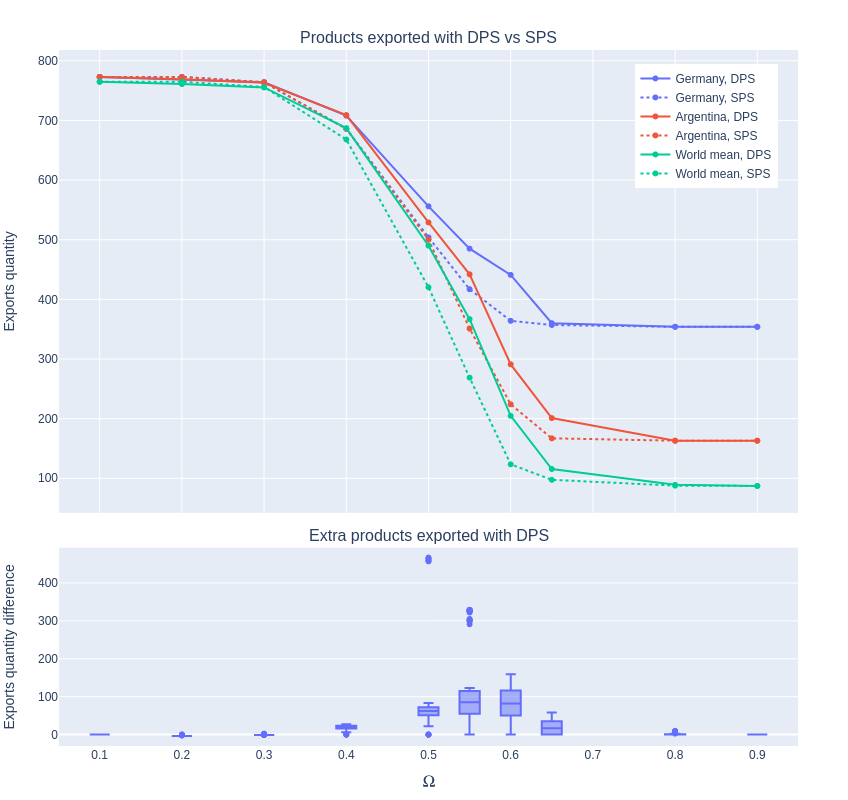

In [16]:
fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    row_heights=[70,30],
                    vertical_spacing=0.05,
                    subplot_titles=[
                        "Products exported with DPS vs SPS",
                        "Extra products exported with DPS"
                    ])
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig1 = px.line(
    df_,
    x="omega",
    y="count_exports",
    color="country",
    line_dash="dynamic",
    markers=True,
    height=600,
    range_y=[0,800],
#    title="Exportaciones por país y variante de simulación"
)

for trace in fig1["data"]:
    #print(trace)
    fig.append_trace(trace, row=1, col=1)

fig2 = px.box(
    max_diff_df.reset_index(),
    x="omega",
    y="difference",
#    title=f"Distribucion de la ventaja de la variante global respecto a la variante local<br>según omega para todos los países (ultima generacion)",
    labels={
        "difference": "Difference between models",
        "omega": "Threshold"})

for trace in fig2["data"]:
    fig.append_trace(trace, row=2, col=1)
fig.update_layout(margin=dict(l=50,r=50,b=50,t=50))
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0.1,
        dtick = 0.1
    ), xaxis2 = dict(
        tickmode = 'linear',
        tick0 = 0.1,
        dtick = 0.1,
        title = "$\Omega$"
    ),
    yaxis = dict(title="Exports quantity"),
    yaxis2 = dict(title="Exports quantity difference"),
    legend=dict(
        x=0.78,
        y=0.98,
        traceorder='normal'
    ),
)

fig.show()